In [1]:
import sys 
sys.path += ["../src"]
import BC_leaders, BC_update
import numpy as np
from tqdm import tqdm
from time import time
import pickle
from glob import glob
from pyABC_ import pyabc
from scipy.special import expit as np_sigmoid

import os
from tempfile import gettempdir
from pyABC_.pyabc.sampler import SingleCoreSampler
from jax.scipy.special import expit as sigmoid
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS
from numpyro.infer.autoguide import AutoNormal, AutoBNAFNormal, AutoIAFNormal
from numpyro import distributions
import numpyro
from numpyro.optim import Adam
import jax.random as random
from datetime import timedelta
# numpyro.set_platform("gpu")
from diptest import dipstat
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt

/home/jacopo.lenti/miniconda3/envs/lotm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
from importlib import reload
reload(BC_update)

<module 'BC_update' from '/home/jacopo.lenti/LOTM/notebooks/../src/BC_update.py'>

In [5]:
#### previous update ####


######## numpyro #############
def count_s_from_edge(e): # e = (u,v,s,t)
    e = jnp.int32(e)
    e_unique_pairs, e_unique_count = jnp.unique(e, axis = 0, return_counts = True)
    e_unique_weigths = e_unique_pairs[:,2] * e_unique_count
    return e_unique_weigths, e_unique_pairs[:,:2]

def edges_coo_mu(edges, N):
    M_list = [sparse.BCOO(count_s_from_edge(edges[t]),
                          shape = jnp.array([N,N])) for t in range(len(edges))]
    return M_list

def compute_Xt(Xt, M_plus_t, M_minus_t, mu_plus, mu_minus):
    M_plus_t_dense, M_minus_t_dense  = M_plus_t.todense(), M_minus_t.todense()
    diff_X_plus = (Xt * M_plus_t_dense.T).sum(axis = 1) - (Xt * M_plus_t_dense).sum(axis = 0)
    diff_X_minus = (Xt * M_minus_t_dense.T).sum(axis = 1) - (Xt * M_minus_t_dense).sum(axis = 0)
    updates_plus = mu_plus * diff_X_plus
    updates_minus = mu_minus * diff_X_minus
    Xt = Xt + updates_plus - updates_minus
    Xt_data_clipped = jnp.clip(Xt.copy(), 0, 1)
    Xt = Xt_data_clipped
    return Xt


def update_X(M_plus, M_minus, mu_plus, mu_minus, Xt, X_list = [], t = 0, T_max = 0):
    M_plus_t, M_minus_t = M_plus[t], M_minus[t]
    Xt = compute_Xt(Xt, M_plus_t, M_minus_t, mu_plus, mu_minus)
    X_list.append(Xt[None,:])
    t += 1
    if t < T_max-1:
        update_X(M_plus, M_minus, mu_plus, mu_minus, Xt, X_list, t, T_max)
        
    return X_list


In [6]:
#### new update M ####


######## numpyro #############
def count_s_from_edge(e): # e = (u,v,s,t)
    e = jnp.int32(e)
    e_unique_pairs, e_unique_count = jnp.unique(e, axis = 0, return_counts = True)
    e_unique_weigths = e_unique_pairs[:,2] * e_unique_count
    return e_unique_weigths, e_unique_pairs[:,:2]

def edges_coo_mu(edges, N):
    M_list = [sparse.BCOO(count_s_from_edge(edges[t]),
                          shape = jnp.array([N,N])).todense() for t in range(len(edges))]
    return M_list

def compute_Xt(Xt, M_plus_t_dense, M_minus_t_dense, mu_plus, mu_minus):
    # M_plus_t_dense, M_minus_t_dense  = M_plus_t.todense(), M_minus_t.todense()
    diff_X_plus = (Xt * M_plus_t_dense.T).sum(axis = 1) - (Xt * M_plus_t_dense).sum(axis = 0)
    diff_X_minus = (Xt * M_minus_t_dense.T).sum(axis = 1) - (Xt * M_minus_t_dense).sum(axis = 0)
    updates_plus = mu_plus * diff_X_plus
    updates_minus = mu_minus * diff_X_minus
    Xt = Xt + updates_plus - updates_minus
    Xt_data_clipped = jnp.clip(Xt.copy(), 0, 1)
    Xt = Xt_data_clipped
    return Xt


def update_X(M_plus, M_minus, mu_plus, mu_minus, Xt, X_list = [], t = 0, T_max = 0):
    M_plus_t, M_minus_t = M_plus[t], M_minus[t]
    Xt = compute_Xt(Xt, M_plus_t, M_minus_t, mu_plus, mu_minus)
    X_list.append(Xt[None,:])
    t += 1
    if t < T_max-1:
        update_X(M_plus, M_minus, mu_plus, mu_minus, Xt, X_list, t, T_max)
        
    return X_list


In [7]:
#### new update ####

def compute_X_from_X0_params(X0, edges_iter, epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho):
    # edges_iter = (edges_t for edges_t in edges)
    # Xt = jax.lax.stop_gradient(X0.copy())
    Xt = X0.copy()
    X_list = [Xt]
    
    N = len(Xt)
    
    while True:
        edges_t = next(edges_iter, None)
        if edges_t is None:
            break
        
        # u,v,_,_ = edges_t.T
        u,v,s_plus,s_minus = edges_t.T
        u,v = u.astype(int),v.astype(int)
        diff_X = Xt[u] - Xt[v]
        # s_plus = ((np.random.rand(edge_per_t) < np_sigmoid(rho * (epsilon_plus - np.abs(diff_X))))) + 0
        # s_minus = ((np.random.rand(edge_per_t) < np_sigmoid(-rho * (epsilon_minus - np.abs(diff_X))))) + 0
        # s_plus =  (np.abs(diff_X) < epsilon_plus) + 0
        # s_minus = (np.abs(diff_X) > epsilon_minus) + 0

        updates_plus = mu_plus * s_plus * diff_X
        updates_minus = mu_minus * s_minus * diff_X
        Xt = Xt.at[v].add(updates_plus - updates_minus).clip(1e-5, 1 - 1e-5)
        # Xt[v] += updates_plus - updates_minus
        # Xt[v] = np.clip(Xt[v], 1e-5, 1 - 1e-5)
        
        X_list.append(Xt)

    return jnp.stack(X_list)


In [8]:
# def initialize_training(X, edges, rho = 32):
#     T, N = X.shape    
#     edges_iter = (edges_t for edges_t in edges)
#     u,v,s_plus,s_minus,t = BC_leaders.convert_edges_uvst(edges)
#     s_plus, s_minus = jnp.float32(s_plus), jnp.float32(s_minus)

#     # X0 = np.array(X[0])
#     X0 = jnp.array(X[0].copy())
#     return {"u": u, "v": v, "s_plus": s_plus, "s_minus": s_minus, "t": t,
#             "N": N, "T": T, "rho": rho, "X0": X0,# "edges":edges
#             "edges_iter": edges_iter
#             }

def initialize_training(X, edges, rho = 32):
    T, N = X.shape    
    u,v,s_plus,s_minus,t = BC_leaders.convert_edges_uvst(edges)
    s_plus, s_minus = jnp.float32(s_plus), jnp.float32(s_minus)

    M_plus_list = edges_coo_mu(edges[:,:,[0,1,2]], N)
    M_minus_list = edges_coo_mu(edges[:,:,[0,1,3]], N)

    X0 = jnp.array(X[0])
    return {"u": u, "v": v, "s_plus": s_plus, "s_minus": s_minus, "t": t,
            "N": N, "T": T, "rho": rho, "X0": X0, 
            "M_plus_list": M_plus_list, "M_minus_list": M_minus_list}



In [9]:
def model(data):
    dim = 4
    dist = distributions.Normal(jnp.zeros(dim), jnp.ones(dim)).to_event(1)
    params = numpyro.sample("theta", dist)
    
    theta = params[:4]
    epsilon_plus, epsilon_minus, mu_plus, mu_minus = sigmoid(theta) /  jnp.array([2,2,5,5]) + jnp.array([0.,.5, 0., 0.])

    ############
    X0,u,v,s_plus, s_minus,t, M_plus_list, M_minus_list, rho, N, T = [data[k] for k in ["X0","u","v","s_plus", "s_minus","t",
                                                                            "M_plus_list", "M_minus_list", "rho", "N", "T"]]
    
    X_sparse_list = update_X(M_plus_list, M_minus_list, mu_plus, mu_minus, X0, 
                             X_list = [X0[None,:]], t = 0, T_max = T)
    X = jnp.concatenate(X_sparse_list)
    ###########
    #new
    # X0,u,v,s_plus, s_minus,t, edges_iter, rho, N, T = [data[k] for k in ["X0","u","v",
    #                                                                      "s_plus", "s_minus","t",
    #                                                                      "edges_iter", "rho", "N", "T"]]
    # X = compute_X_from_X0_params(X0, edges_iter, epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho)
    ######
    
    u,v,t = u.astype(int),v.astype(int),t.astype(int)
    diff_X = X[t,u] - X[t,v]

    kappas_plus = BC_leaders.kappa_plus_from_epsilon(epsilon_plus, diff_X, rho, with_jax = True)
    kappas_minus = BC_leaders.kappa_minus_from_epsilon(epsilon_minus, diff_X, rho, with_jax = True)
    kappas_ = jnp.concatenate([kappas_minus, kappas_plus])
    s = jnp.concatenate([s_minus, s_plus])

    with numpyro.plate("data", s.shape[0]):
        numpyro.sample("obs", distributions.Bernoulli(probs = kappas_), obs = s)



In [10]:
# X0,u,v,s_plus, s_minus,t, edges_iter, rho, N, T = [data[k] for k in ["X0","u","v",
#                                                                          "s_plus", "s_minus","t",
#                                                                          "edges", "rho", "N", "T"]]
    

In [11]:
# X = compute_X_from_X0_params(X0, edges_iter, epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho)

In [12]:
def train_mcmc(X, edges, intermediate_samples = None, rho = 32, num_chains = 1,
               warmup_samples = None, n_samples = 400, progress_bar = False, id = None, timeout = 3600):
    if intermediate_samples is None:
        intermediate_samples = n_samples
    if warmup_samples is None:
        warmup_samples = intermediate_samples

    data = initialize_training(jnp.array(X), jnp.array(edges), rho = rho)
    key = random.PRNGKey(0)
    mcmc = MCMC(NUTS(model), num_warmup = warmup_samples, num_chains = num_chains, 
                num_samples = intermediate_samples, progress_bar = progress_bar)
    res = []
    tot_time = 0
    for _ in range(int(n_samples / intermediate_samples)):
        t0 = time()
        mcmc.run(key, data)
        t1 = time()
        tot_time += t1 - t0

        mcmc.post_warmup_state = mcmc.last_state
        key = mcmc.post_warmup_state.rng_key
        
        mcmc_samples = mcmc.get_samples()
        param_mean, param_std = analyse_samples(mcmc_samples["theta"])
        res.append({"param_mean": param_mean,
                    "param_std": param_std,
                    "tot_time": tot_time,
                    "n_simulations": None,
                    "method": "mcmc",
                    "n_steps": None,
                    "n_samples": intermediate_samples * (_ + 1),
                    "id": id})
        if tot_time > timeout:
            break

    return res



In [13]:
def train_svi(X, edges, guide_family = "normal", rho = 32,
              n_steps = 4000, intermediate_steps = None, lr = 0.01, 
              progress_bar = False, id = None, timeout = 3600):
    if intermediate_steps is None:
        intermediate_steps = n_steps
    
    if guide_family == "normal":
        guide = AutoNormal(model)
    if guide_family == "NF":
        guide = AutoBNAFNormal(model, num_flows = 1, hidden_factors = (8,8))
        n_steps = int(n_steps / 2)
        intermediate_steps = int(intermediate_steps / 2)
    
    data = initialize_training(jnp.array(X), jnp.array(edges), rho = rho)
    optimizer = Adam(step_size = lr)
    svi = SVI(model, guide, optimizer, loss = TraceGraph_ELBO())
    res = []
    last_state = None

    tot_time = 0
    
    for _ in range(int(n_steps / intermediate_steps)):
        t0 = time()
        svi_results = svi.run(random.PRNGKey(0), intermediate_steps, data, init_state = last_state, progress_bar = progress_bar)
        t1 = time()
        tot_time += t1 - t0

        theta_samples = guide.sample_posterior(random.PRNGKey(0), svi_results.params, sample_shape = (200,))["theta"]
        param_mean, param_std = analyse_samples(theta_samples)
        
        res_analysis = {"param_mean": param_mean,
                        "param_std": param_std,
                        "tot_time": tot_time,
                        "n_simulations": None,
                        "method": "svi" + guide_family,
                        "n_steps": intermediate_steps * (_ + 1),
                        "n_samples": None,
                        "id": id
                        }
        res.append(res_analysis)

        last_state = svi_results.state
        if tot_time > timeout:
            break

    return res


In [14]:
######## pyabc #############
# def create_s_update_X(X_t, edges_iter, edge_per_t, parameters, rho,
#                      summary_statistics_list, X_list):
#     edges_t = next(edges_iter, None)
#     if edges_t is not None:
#         epsilon_plus,epsilon_minus, mu_plus, mu_minus = epsilons_from_theta(parameters, dict_theta = True, numpy = True)
#         u,v,_,_ = edges_t.T

#         diff_X = X_t[u] - X_t[v]
#         s_plus = ((np.random.rand(edge_per_t) < np_sigmoid(rho * (epsilon_plus - np.abs(diff_X))))) + 0
#         s_minus = ((np.random.rand(edge_per_t) < np_sigmoid(-rho * (epsilon_minus - np.abs(diff_X))))) + 0

#         updates_plus = mu_plus * s_plus * diff_X 
#         updates_minus = mu_minus * s_minus * diff_X 
#         X_t[v] += updates_plus - updates_minus
#         X_t[v] = np.clip(X_t[v], 1e-5, 1 - 1e-5)
#         X_list.append(X_t[None,:].copy())
#         summary_statistics_list.append(np.concatenate([u[None,:],v[None,:],s_plus[None,:], s_minus[None,:]])[None,:])
#         create_s_update_X(X_t, edges_iter, edge_per_t, parameters, rho, summary_statistics_list, X_list)
#     edges_sim = np.concatenate(summary_statistics_list).transpose(0,2,1)
#     return {"s_plus_sum": edges_sim[:,:,-2].sum(axis = 1), 
#             "s_minus_sum": edges_sim[:,:,-1].sum(axis = 1)}

def create_summary_statistics(X0, edges_iter, edge_per_t, parameters, rho):
    summary_statistics_list = []
    Xt = X0.copy()
    N = len(Xt)
    
    while True:
        edges_t = next(edges_iter, None)
        if edges_t is None:
            break
        epsilon_plus,epsilon_minus, mu_plus, mu_minus = epsilons_from_theta(parameters, dict_theta = True, numpy = True)
        u,v,_,_ = edges_t.T
        u,v = u.astype(int),v.astype(int)
        diff_X = Xt[u] - Xt[v]
        # s_plus = ((np.random.rand(edge_per_t) < np_sigmoid(rho * (epsilon_plus - np.abs(diff_X))))) + 0
        # s_minus = ((np.random.rand(edge_per_t) < np_sigmoid(-rho * (epsilon_minus - np.abs(diff_X))))) + 0
        s_plus =  (np.abs(diff_X) > epsilon_plus) + 0
        s_minus = (np.abs(diff_X) < epsilon_minus) + 0

        updates_plus = mu_plus * s_plus * diff_X 
        updates_minus = mu_minus * s_minus * diff_X 
        Xt[v] += updates_plus - updates_minus
        Xt[v] = np.clip(Xt[v], 1e-5, 1 - 1e-5)
            
        summary_statistics_list.append(np.concatenate([u[None,:],v[None,:],s_plus[None,:], s_minus[None,:]])[None,:])

    edges_sim = np.concatenate(summary_statistics_list).transpose(0,2,1)
    return {"s_plus_sum": edges_sim[:,:,-2].sum(axis = 1), 
            "s_minus_sum": edges_sim[:,:,-1].sum(axis = 1)}

    

def create_trajectory(X0, edges, parameters, rho):
    X0 = X0.copy()
    edges_iter = (edges_t for edges_t in edges)
    T, edge_per_t, _ = edges.shape
    summary_statistics = create_summary_statistics(X0, edges_iter, edge_per_t, parameters, rho)
    # summary_statistics = create_s_update_X(X0, edges_iter, edge_per_t, parameters, rho, [], [X0[None,:].copy()])
    return summary_statistics

def sim_trajectory_X0_edges(X0, edges, rho):
    return lambda parameters: create_trajectory(X0, edges, parameters, rho)



def train_abc(X, edges, populations_budget = 10, intermediate_populations = None,
              population_size = 200, rho = 32, id = None, timeout = 3600):
    if intermediate_populations is None:
        intermediate_populations = populations_budget
    
    T = len(X)
    res = []
    tot_time = 0
    model_abc = sim_trajectory_X0_edges(X[0], edges, rho)
    prior = pyabc.Distribution(
                theta0=pyabc.RV("norm", 0, 1),
                theta1=pyabc.RV("norm", 0, 1),
                theta2=pyabc.RV("norm", 0, 1),
                theta3=pyabc.RV("norm", 0, 1))
    distance = pyabc.PNormDistance(2)
    obs = {"s_plus_sum": edges[:,:,-2].sum(axis = 1), 
           "s_minus_sum": edges[:,:,-1].sum(axis = 1)}
    abc = pyabc.ABCSMC(model_abc, prior, distance, population_size = population_size)#, sampler = SingleCoreSampler())
    db = "sqlite:///" + os.path.join(gettempdir(), f"{id}_update_test.db")
    history = abc.new(db, obs)
    run_id = history.id
    for _ in range(int(populations_budget / intermediate_populations)):
        abc_continued = pyabc.ABCSMC(model_abc, prior, distance, population_size = population_size)#, sampler = SingleCoreSampler())
        abc_continued.load(db, run_id)
        t0 = time()
        history = abc_continued.run(max_nr_populations = intermediate_populations,
                                    minimum_epsilon = 5 * (T ** (1/2)),
                                    max_walltime = timedelta(hours = 3))
        t1 = time()
        tot_time += (t1 - t0)
        theta_samples = jnp.array(history.get_distribution()[0])

        param_mean, param_std = analyse_samples(theta_samples)
        res_analysis = {"param_mean": param_mean,
                        "param_std": param_std,
                        "tot_time": tot_time,
                        "n_simulations": history.total_nr_simulations,
                        "method": "abc",
                        "n_steps": None,
                        "n_samples": None,
                        "id": id
                        }
        res.append(res_analysis)
        if tot_time > timeout:
            break
    return res





In [15]:
def count_interactions(X, edges):
    T, N = X.shape
    _,edge_per_t,_ = edges.shape
    
    pos_interactions_plus, pos_interactions_minus = edges[:,:,2].sum(), edges[:,:,3].sum()
    tot_interactions = (T - 1) * edge_per_t
    

    return {"pos_interactions_plus":pos_interactions_plus, 
            "pos_interactions_minus":pos_interactions_minus, 
            "tot_interactions":tot_interactions,
            "T": T, "N": N, "edge_per_t": edge_per_t,
            "var_X_end": X[-1].var(),
            "skew_X_end": skew(X[-1]),
            "kurtosis_X_end": kurtosis(X[-1]),
            "bimodality_X_end": dipstat(X[-1]),
            }

########## all ##############
def epsilons_from_theta(parameters, dict_theta = False, numpy = False):
    
    sigmoid_fn = np_sigmoid if numpy else sigmoid
    if dict_theta:
        epsilon_plus = sigmoid_fn(parameters["theta0"]) / 2
        epsilon_minus = sigmoid_fn(parameters["theta1"]) / 2 + .5
        mu_plus = sigmoid_fn(parameters["theta2"]) / 10
        mu_minus = sigmoid_fn(parameters["theta3"]) / 10
        return epsilon_plus,epsilon_minus, mu_plus, mu_minus
    elif len(parameters.shape) == 1:
        epsilon_plus,epsilon_minus, mu_plus, mu_minus = sigmoid(parameters) / jnp.array([2,2,10,10]) + jnp.array([0.,.5,0.,0.])
        return epsilon_plus,epsilon_minus, mu_plus, mu_minus
    else:
        trans_theta = (sigmoid(parameters) / jnp.array([2,2,10,10]) + jnp.array([0.,.5,0.,0.])).T
        return trans_theta

def analyse_samples(samples):
        param_samples = epsilons_from_theta(samples, dict_theta = False, numpy = False).T
        param_mean, param_std = param_samples.mean(axis = 0), param_samples.std(axis = 0)
        
        return param_mean, param_std

def analyse_results(epsilon_plus, epsilon_minus, mu_plus, mu_minus, 
                    param_mean, param_std, n_samples, n_steps, n_simulations, id,
                    tot_time, method):
    params = np.array([epsilon_plus, epsilon_minus, mu_plus, mu_minus])

    param_names = ["epsilon_plus", "epsilon_minus", "mu_plus", "mu_minus"]
    out = {
            "id": id,
            "mse_params": ((params - param_mean)**2).mean().item(), 
            "mse_epsilon": ((params[:2] - param_mean[:2])**2).mean().item(), 
            "mse_mu": ((params[2:] - param_mean[2:])**2).mean().item(), 
            "tot_time": tot_time,
            "n_steps": n_steps, 
            "n_samples": n_samples,
            "method": method,
            "n_simulations": n_simulations
            }

    out.update({u + "_error": np.abs(params[k] - param_mean[k]) for k, u in enumerate(param_names)})
    out.update({u + "_mean": param_mean[k].item() for k, u in enumerate(param_names)})
    out.update({u + "_std": param_std[k].item() for k, u in enumerate(param_names)})
    out.update({u + "_real": params[k].item() for k, u in enumerate(param_names)})

    return out
        

def save_pickle(out, path):
    if path is not None:
        with open(path, "wb") as f:
            pickle.dump(out, f)




In [16]:
def complete_experiment(N, T, edge_per_t, rho = 32,
                        method = "svinormal",
                        epsilon_plus = None, epsilon_minus = None, mu_plus = None, mu_minus = None,
                        n_steps = 1000, n_samples = 100, populations_budget = 10, num_chains = 1,
                        intermediate_steps = None, intermediate_samples = None, warmup_samples = None, 
                        intermediate_populations = None, population_size = 200, 
                        lr = 0.01, progress_bar = False, timeout = 25000, id = None, date = None, save_data = True
                        ):
    if len(glob(f"../data/update_{date}/X_{id}*")) > 0:
        X_file = glob(f"../data/update_{date}/X_{id}*")[0]
        edges_file = glob(f"../data/update_{date}/edges_{id}*")[0]
        X = np.load(X_file)
        edges = np.load(edges_file)
        
        _,_,epsilon_plus,epsilon_minus, mu_plus, mu_minus = [int(u) for u in X_file.split("/")[-1].split("_")[2:-1]]
        epsilon_plus, epsilon_minus, mu_plus, mu_minus = np.array([epsilon_plus, epsilon_minus, mu_plus, mu_minus]) / 100
    else:
        if epsilon_plus is None:
            epsilon_plus = np.random.randint(5) * 0.1 + 0.05
            epsilon_minus = np.random.randint(5) * 0.1 + 0.55
            mu_plus = np.random.randint(5) * 0.02 + 0.01
            mu_minus = np.random.randint(5) * 0.02 + 0.01

        X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t, 
                                                  epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus, 
                                                  mu_plus = mu_plus, mu_minus = mu_minus, rho = rho)  


        if save_data:
            np.save(f"../data/update_{date}/X_{id}_{int(epsilon_plus * 100)}_{int(epsilon_minus * 100)}_{int(mu_plus * 100)}_{int(mu_minus * 100)}_.npy", X)
            np.save(f"../data/update_{date}/edges_{id}_{int(epsilon_plus * 100)}_{int(epsilon_minus * 100)}_{int(mu_plus * 100)}_{int(mu_minus * 100)}_.npy", edges)
        

    analysis_data = count_interactions(X, edges)
    
    
    out = []
    if method == "svinormal":
        res_svinormal = train_svi(X, edges, guide_family = "normal", rho = rho,
             n_steps = n_steps, intermediate_steps = intermediate_steps, lr = lr, 
             progress_bar = progress_bar, id = id, timeout = timeout)
        out += res_svinormal
    if method == "sviNF":
        res_svinf = train_svi(X, edges, guide_family = "NF", rho = rho,
             n_steps = n_steps, intermediate_steps = intermediate_steps, lr = lr, 
             progress_bar = progress_bar, id = id, timeout = timeout)
        out += res_svinf
    if method == "mcmc":
        res_mcmc = train_mcmc(X, edges, intermediate_samples = intermediate_samples, warmup_samples = warmup_samples,  rho = rho,
                              n_samples = n_samples, num_chains = num_chains, progress_bar = progress_bar, id = id, timeout = timeout)
        out += res_mcmc
    if method == "abc":
        res_abc = train_abc(X, edges, populations_budget = populations_budget, intermediate_populations = intermediate_populations,
                            population_size = population_size, rho = rho, id = id, timeout = timeout)
        out += res_abc
    complete_analysis = [analyse_results(epsilon_plus, epsilon_minus, mu_plus, mu_minus, **res)|analysis_data for res in out]
    return complete_analysis
    # return out, analysis_data




In [30]:
N = 24
T = 32
edge_per_t = 10
epsilon_plus = 0.17
epsilon_minus = 0.8
mu_plus = 0.15
mu_minus = 0.15
rho = 32

In [36]:
reload(BC_update)

<module 'BC_update' from '/home/jacopo.lenti/LOTM/notebooks/../src/BC_update.py'>

In [49]:
X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t,
                                         epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus,
                                         mu_plus = mu_plus, mu_minus = mu_minus, rho = rho, seed =911)


0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925293213
0.9409368925

In [28]:
X[0]

array([0.11098208, 0.52828345, 0.10517383, 0.02962699, 0.38361536,
       0.73330346, 0.13004042, 0.4240138 , 0.34424028, 0.39876471,
       0.11152916, 0.58617412, 1.07835229, 0.24702135, 0.59681741,
       0.4881513 , 0.06225402, 0.96183807, 0.09958023, 0.44305149,
       0.75498761, 0.2984281 , 0.42051576, 0.84029309])

In [66]:
res_svinf = train_svi(X, edges, guide_family = "NF", rho = 32,
             n_steps = 10000, intermediate_steps = None, lr = 0.01,
             progress_bar = True)

100%|██████████| 5000/5000 [00:15<00:00, 326.16it/s, init loss: 227.9784, avg. loss [4751-5000]: 39.5637] 


In [67]:
res_svinf

[{'param_mean': Array([0.16395636, 0.79016834, 0.07727702, 0.05701572], dtype=float32),
  'param_std': Array([0.00728072, 0.0178784 , 0.0102335 , 0.01618248], dtype=float32),
  'tot_time': 20.540714025497437,
  'n_simulations': None,
  'method': 'sviNF',
  'n_steps': 5000,
  'n_samples': None,
  'id': None}]

In [69]:
N = 20
tot_times = []
for T in [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    print(T)
    X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t,
                                         epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus,
                                         mu_plus = mu_plus, mu_minus = mu_minus, rho = rho)
    res_svinf = train_svi(X, edges, guide_family = "NF", rho = 32,
             n_steps = 10000, intermediate_steps = None, lr = 0.01,
             progress_bar = True)
    tot_times.append((T, res_svinf[0]["tot_time"]))
    


10


100%|██████████| 5000/5000 [00:04<00:00, 1116.67it/s, init loss: 65.9158, avg. loss [4751-5000]: 8.5953]


15


100%|██████████| 5000/5000 [00:06<00:00, 750.40it/s, init loss: 100.0989, avg. loss [4751-5000]: 18.8588] 


20


100%|██████████| 5000/5000 [00:11<00:00, 452.76it/s, init loss: 140.5759, avg. loss [4751-5000]: 21.1834] 


25


100%|██████████| 5000/5000 [00:14<00:00, 352.49it/s, init loss: 173.0278, avg. loss [4751-5000]: 28.1553] 


30


100%|██████████| 5000/5000 [00:16<00:00, 300.98it/s, init loss: 191.2382, avg. loss [4751-5000]: 35.6772]


35


100%|██████████| 5000/5000 [00:21<00:00, 227.52it/s, init loss: 147.4474, avg. loss [4751-5000]: 36.8972]


40


100%|██████████| 5000/5000 [00:25<00:00, 195.96it/s, init loss: 253.1107, avg. loss [4751-5000]: 38.9031]


45


100%|██████████| 5000/5000 [00:32<00:00, 153.56it/s, init loss: 186.9944, avg. loss [4751-5000]: 48.4145]


50


100%|██████████| 5000/5000 [00:39<00:00, 127.87it/s, init loss: 414.3330, avg. loss [4751-5000]: 61.7823]


55


100%|██████████| 5000/5000 [00:48<00:00, 103.34it/s, init loss: 355.9933, avg. loss [4751-5000]: 47.9289]


60


100%|██████████| 5000/5000 [01:02<00:00, 79.59it/s, init loss: 315.6882, avg. loss [4751-5000]: 32.2406] 


In [89]:
s = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
np.exp(s / 30) + 10

array([ 11.39561243,  11.94773404,  12.71828183,  13.79366789,
        15.29449005,  17.3890561 ,  20.3122585 ,  24.3919161 ,
        30.08553692,  38.03162489,  49.121284  ,  64.59815003,
        86.19785657, 116.3426754 ])

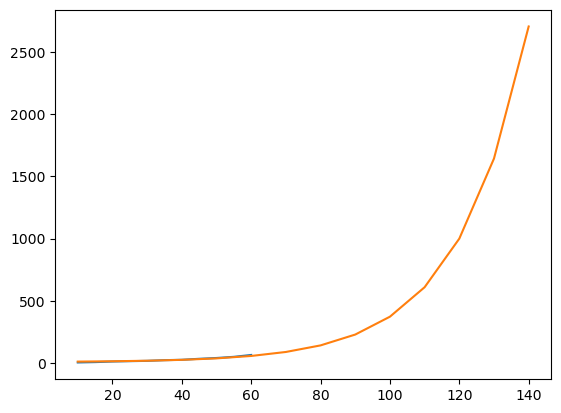

In [109]:
plt.plot(np.array(tot_times)[:,0], np.array(tot_times)[:,1])
plt.plot(s, np.exp((s + 18) / 20) + 8)

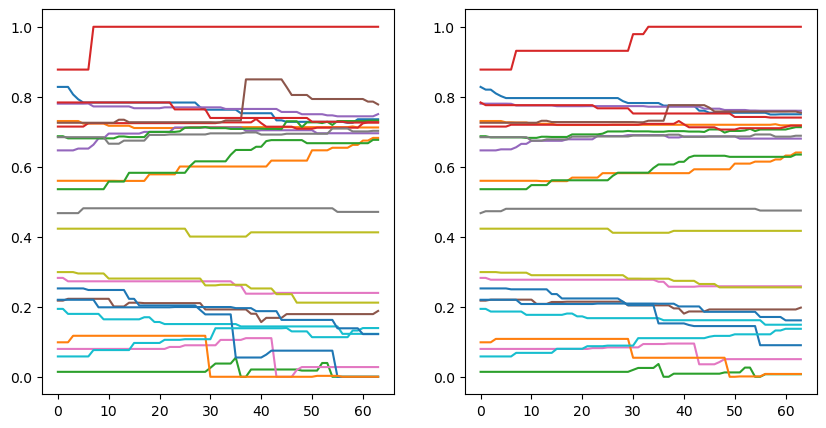

In [43]:
fig, axes = plt.subplots(ncols = 2, figsize = (10, 5))
X0 =jnp.array(X[0])
edges_iter = (edge_t for edge_t in edges)

X1 = compute_X_from_X0_params(X0, edges_iter, res_svinf[0]["param_mean"][0],res_svinf[0]["param_mean"][1],
                              # mu_plus, mu_minus,
                              res_svinf[0]["param_mean"][2], res_svinf[0]["param_mean"][3], 
                            # 0.01,0.2,
                              rho)
axes[0].plot(X)
axes[1].plot(X1)

fig.show()

In [56]:
import pandas as pd

In [69]:
#exps =[]
exps += [[[analyse_results(epsilon_plus, epsilon_minus, mu_plus, mu_minus, **res) for res in res_svinf][0][u] for u in ["epsilon_plus_error", "epsilon_minus_error", "mu_plus_error", "mu_minus_error", "tot_time"]] + [16, 1, "TraceGraph_ELBO"]]
pd.DataFrame(exps, columns = ["epsilon_plus_error", "epsilon_minus_error", "mu_plus_error", "mu_minus_error", "tot_time", "hidden_factors", "flows", "loss"])

,epsilon_plus_error,epsilon_minus_error,mu_plus_error,mu_minus_error,tot_time,hidden_factors,flows,loss
0,0.009659,0.069949,0.034028,0.016305,98.415250,16,1,TraceGraph_ELBO
1,0.011245,0.045665,0.025068,0.022351,90.856867,16,1,TraceGraph_ELBO
2,0.011245,0.045665,0.025068,0.022351,90.856867,16,1,TraceGraph_ELBO
3,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
4,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
5,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
6,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
7,0.011434,0.045747,0.025504,0.022913,93.569907,16,1,TraceGraph_ELBO
8,0.008386,0.000122,0.021417,0.023163,129.072983,16,1,TraceGraph_ELBO


In [31]:
exp = complete_experiment(N = 100, T = 20, edge_per_t = 5, rho = 32,
                    method = "sviNF",
                    epsilon_plus = None, epsilon_minus = None, mu_plus = None, mu_minus = None,
                    n_steps = 1000, n_samples = 100, populations_budget = 10, num_chains = 1,
                    intermediate_steps = None, intermediate_samples = None, warmup_samples = None, 
                    intermediate_populations = None, population_size = 200, progress_bar = True,
                    lr = 0.01, timeout = 25000, id = None, date = None, save_data = False
                        )

100%|██████████| 500/500 [01:48<00:00,  4.60it/s, init loss: 85.7430, avg. loss [476-500]: 13.4207]


In [32]:
exp

[{'id': None,
  'mse_params': 0.00040177247137762606,
  'mse_epsilon': 0.0002082852879539132,
  'mse_mu': 0.000595259596593678,
  'tot_time': 112.77577471733093,
  'n_steps': 500,
  'n_samples': None,
  'method': 'sviNF',
  'n_simulations': None,
  'epsilon_plus_error': 0.0010448545,
  'epsilon_minus_error': 0.020383298,
  'mu_plus_error': 0.034335658,
  'mu_minus_error': 0.0034032129,
  'epsilon_plus_mean': 0.2489551454782486,
  'epsilon_minus_mean': 0.7296167016029358,
  'mu_plus_mean': 0.05566434562206268,
  'mu_minus_mean': 0.05340321362018585,
  'epsilon_plus_std': 0.013606677763164043,
  'epsilon_minus_std': 0.024680383503437042,
  'mu_plus_std': 0.022995080798864365,
  'mu_minus_std': 0.021685583516955376,
  'epsilon_plus_real': 0.25,
  'epsilon_minus_real': 0.75,
  'mu_plus_real': 0.09,
  'mu_minus_real': 0.05,
  'pos_interactions_plus': 41.0,
  'pos_interactions_minus': 6.0,
  'tot_interactions': 95,
  'T': 20,
  'N': 100,
  'edge_per_t': 5,
  'var_X_end': 0.08939463170579415,

In [ ]:
if __name__ == '__main__':
    T, N = [int(sys.argv[k + 2]) for k in range(2)]
    method = sys.argv[4]
    date = sys.argv[5]

    rep = sys.argv[1]
    t0 = time()
    edge_per_t = 10

    id = f"{rep}_{N}_{T}"
    
    if not os.path.exists(f"../data/update_{date}"):
        try:
            os.mkdir(f"../data/update_{date}")
        except:
            None
    
    path = f"../data/update_{date}/estimation_T{T}_N{N}_rep{rep}_method{method}.pkl"

    print(f"++++++ update rep {rep} start {T} {N} {method} ++++++++")

    experiment = complete_experiment(N, T, edge_per_t, rho = 32,                    
                        n_steps=800, n_samples=200, 
                        method = method, populations_budget = 40, #intermediate_populations = 5,
                        population_size = 200, lr = 0.01,
                        id = id, date = date
                        )
    
    save_pickle(experiment, path)

    print(f">>>>>>>> update rep {rep} save {T} {N} {method} {round(time() - t0)}s <<<<<<<")
            


In [70]:
import inference_update

In [ ]:
res_inf = inference_update.train_svi(X, edges, guide_family = "NF", rho = 32,
             n_steps = 10000, intermediate_steps = None, lr = 0.01,
             progress_bar = True)
